In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
import os
from dotenv import load_dotenv

In [2]:
model=ChatGoogleGenerativeAI(model='gemini-1.5-flash')

In [3]:
output=model.invoke("Hi")
print(output.content)

Hi there! How can I help you today?


In [4]:
### loading Embedding model

from langchain_huggingface import HuggingFaceEmbeddings

embedding=HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")

print(len(embedding.embed_query('hi')))

c:\Users\Hp\miniconda3\envs\agentic_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Hp\miniconda3\envs\agentic_venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Hp\.cache\huggingface\hub\models--BAAI--bge-small-en. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate d

384


In [6]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_chroma import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [7]:
text_loader=DirectoryLoader("../05_Langgraph",glob='./*.txt',loader_cls=TextLoader)

In [8]:
text_data=text_loader.load()

In [12]:
text_content=text_data[0].page_content

In [39]:
spliter=RecursiveCharacterTextSplitter(chunk_size=200,chunk_overlap=50)

In [40]:
splited_chunk=spliter.split_documents(text_data)

In [41]:
splited_chunk

[Document(metadata={'source': '..\\05_Langgraph\\usa.txt'}, page_content='🇺🇸 Overview of the U.S. Economy'),
 Document(metadata={'source': '..\\05_Langgraph\\usa.txt'}, page_content='The United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy,'),
 Document(metadata={'source': '..\\05_Langgraph\\usa.txt'}, page_content='It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a'),
 Document(metadata={'source': '..\\05_Langgraph\\usa.txt'}, page_content='a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services.'),
 Document(metadata={'source': '..\\05_Langgraph\\usa.txt'}, page

In [42]:
text_content=[doc.page_content for doc in splited_chunk]

In [ ]:
text_content

['🇺🇸 Overview of the U.S. Economy',
 'The United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy,',
 'It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a',
 'a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services.',
 'innovation, global trade, and financial services. It has a highly diversified structure with strong sectors in technology, healthcare, finance, real estate, defense, and agriculture.',
 'U.S. GDP – Size, Composition, and Global Share',
 'As of 2024, the United States’ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 

In [44]:
len(text_content)

55

In [47]:
vector_store=Chroma.from_documents(splited_chunk,embedding,persist_directory='chroma_db_store')

In [50]:
retriever=vector_store.as_retriever(search_kwargs={'k':5})

In [51]:
retriever.invoke("Industrial growth of USA")

[Document(id='7fe89992-35c8-4966-8dc6-64ccc025f259', metadata={'source': '..\\05_Langgraph\\usa.txt'}, page_content='🇺🇸 Overview of the U.S. Economy'),
 Document(id='a57ca764-4221-487c-9cba-1621a9ca73c1', metadata={'source': '..\\05_Langgraph\\usa.txt'}, page_content='Looking forward, the U.S. economy is expected to grow at a moderate pace, powered by innovation in AI, green energy, robotics, biotech, and quantum computing. The Biden administration’s Inflation'),
 Document(id='ed06451e-2975-44c4-b164-9cd8c83e6e67', metadata={'source': '..\\05_Langgraph\\usa.txt'}, page_content='The U.S. economy remains the engine of global growth, backed by unmatched innovation, financial dominance, and a strong institutional framework. Its $28 trillion GDP and influence over global'),
 Document(id='3a0a5c18-15ca-46c1-9f2b-74779152a42e', metadata={'source': '..\\05_Langgraph\\usa.txt'}, page_content='GDP Growth Trends and Dynamics'),
 Document(id='c2f1e296-675b-4b15-9aac-6c5fd726069e', metadata={'sourc

In [52]:
###Pydantic class

from pydantic import BaseModel,Field

class TopicSelectionParser(BaseModel):
    topic:str=Field(description="selected topic")
    reasoning: str=Field(description="Reason behind the topic selection")



In [53]:
from langchain_core.output_parsers import PydanticOutputParser

parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [55]:
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"topic": {"description": "selected topic", "title": "Topic", "type": "string"}, "reasoning": {"description": "Reason behind the topic selection", "title": "Reasoning", "type": "string"}}, "required": ["topic", "reasoning"]}\n```'

In [57]:
from typing import TypedDict,Annotated,Sequence,operator
from langchain_core.messages import BaseMessage

In [58]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],operator.add]

In [59]:
Agentstate=dict()


In [60]:
Agentstate['message']=[]

In [61]:
Agentstate['message'].append("Hi how are you?")

In [62]:
Agentstate

{'message': ['Hi how are you?']}

In [63]:
Agentstate['message'].append("What are you doing?")

In [64]:
Agentstate

{'message': ['Hi how are you?', 'What are you doing?']}

In [65]:
Agentstate['message'].append("I hope everything is fine.")

In [66]:
Agentstate['message'][-1]

'I hope everything is fine.'

##StateGraph

In [67]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],operator.add]

In [84]:
from langchain_core.prompts import PromptTemplate

In [113]:
def function_1(state:AgentState):
    question=state["messages"][-1]
    print("Question",question)
    prompt=PromptTemplate(
        template="""You are like a classifier, your task is to classify the given user query into one of the
        following categories:[USA,Not Related].
        Only respond with the category name and nothing else.
        User query: {question},
        {format_instructions}""",
        input_variables=["question"],
        partial_variables={"format_instructions":parser.get_format_instructions()}
    )
    chain= prompt | model | parser
    response=chain.invoke({"question":question})
    print("parsed response: ",response)
    return {"messages":[response.topic]}

In [114]:
state={"messages":["What is GDP of largest economy country?"]}

In [115]:
result=function_1(state)
print(result)

Question What is GDP of largest economy country?
parsed response:  topic='USA' reasoning='The query asks about the GDP of the largest economy country, which is implicitly referring to the USA.'
{'messages': ['USA']}


In [116]:
def router(state:AgentState):
    print("-> Router ->")
    last_message=state["messages"][-1]
    print("Last messages: ",last_message)
    if 'usa' in last_message.lower():
        return "RAG call"
    else:
        return "LLM call"

In [117]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

In [153]:
def format_docs(docs):
    return '\n\n'.join(doc.page_content for doc in docs)

In [154]:
###RAG function
def function_2(state:AgentState):
    print("-> RAG function calling ->")
    question=state['messages'][0]
    prompt=PromptTemplate(
        template="""You are an assistant for question answering tasks. use the following piece of retrive context to
         answer the question. If you don't know the answer , just say that you don't know. Use maximum three sentences 
          to provide the answer and it should be consise.\n Question: {question}\n Context: {context}\n Answer: """,
        input_variables=['context','question']
    )
    rag_chain=(
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    response=rag_chain.invoke(question)
    return {"messages":[response]}

In [155]:

### LLM function
def function_3(state:AgentState):
    print("-> LLM function calling ->")
    question=state["messages"][0]
    query="""Please answer the mentioned user query from your knowledge and your answer 
     should be well information and consise with maximum 5 sentenses. User question:"""+ question
    response=model.invoke(query)
    return {"messages": [response.content]}

In [156]:
from langgraph.graph import StateGraph,END

In [157]:
workflow=StateGraph(AgentState)

In [158]:
workflow.add_node("Supervisor",function_1)

In [159]:
workflow.add_node("RAG",function_2)

In [160]:
workflow.add_node("LLM",function_3)

In [161]:
workflow.set_entry_point("Supervisor")

In [162]:
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG call":"RAG",
        "LLM call": "LLM"
    }
)

In [163]:
workflow.add_edge("RAG",END)
workflow.add_edge("LLM",END)

In [164]:
app=workflow.compile()

In [165]:
from IPython.display import Image, display

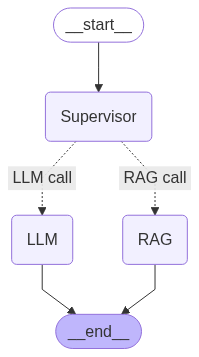

In [166]:
display(Image(app.get_graph().draw_mermaid_png()))

In [167]:
state={"messages":["hi"]}

In [168]:
final_response=app.invoke(state)
print(final_response["messages"][-1])

Question hi
parsed response:  topic='Not Related' reasoning='The query "hi" is a generic greeting and does not relate to the USA.'
-> Router ->
Last messages:  Not Related
-> LLM function calling ->
Hello!  How can I help you today?  Please let me know what you need assistance with. I'm ready to answer your questions.  I can provide information on a wide range of topics.  Don't hesitate to ask!


In [169]:
state

{'messages': ['hi']}

In [170]:
final_response=app.invoke({"messages":["What is the GDP of world largest economy?"]})
print(final_response["messages"][-1])

Question What is the GDP of world largest economy?
parsed response:  topic='USA' reasoning="The world's largest economy is the USA, so the query is related to the USA."
-> Router ->
Last messages:  USA
-> RAG function calling ->
The United States has the world's largest economy.  As of 2024, its nominal GDP is approximately $28 trillion USD. This represents about 25% of the global economy.
